# Sieci konwolucyjne w PyTorch

In [1]:
import torch
import torchvision
import math
import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

Akcelerator obliczeń.

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Układ obliczeniowy: {device}')

Układ obliczeniowy: cuda:0


## Zbiór danych

Przygotowujemy transformację wejściowych zdjęć. Obecnie jest to sekwencja dwóch operacji:
* zdekodowanie obrazu (`ToImage()`),
* konwersja do tensora PyTorch (`ToDtype()`)

In [3]:
from torchvision import transforms

# Sekwencja operacji wykonujących pre-processing danych wejściowych.
input2tensor = transforms.Compose([
    transforms.ToTensor(),
])

Ładujemy dane i wyświetlamy kila przykładowych obrazów.

In [4]:
train_data = torchvision.datasets.FashionMNIST('/tmp/fmnist', transform=input2tensor,
                                               train=True, download=True)
test_data = torchvision.datasets.FashionMNIST('/tmp/fmnist', transform=input2tensor,
                                              train=False, download=True)

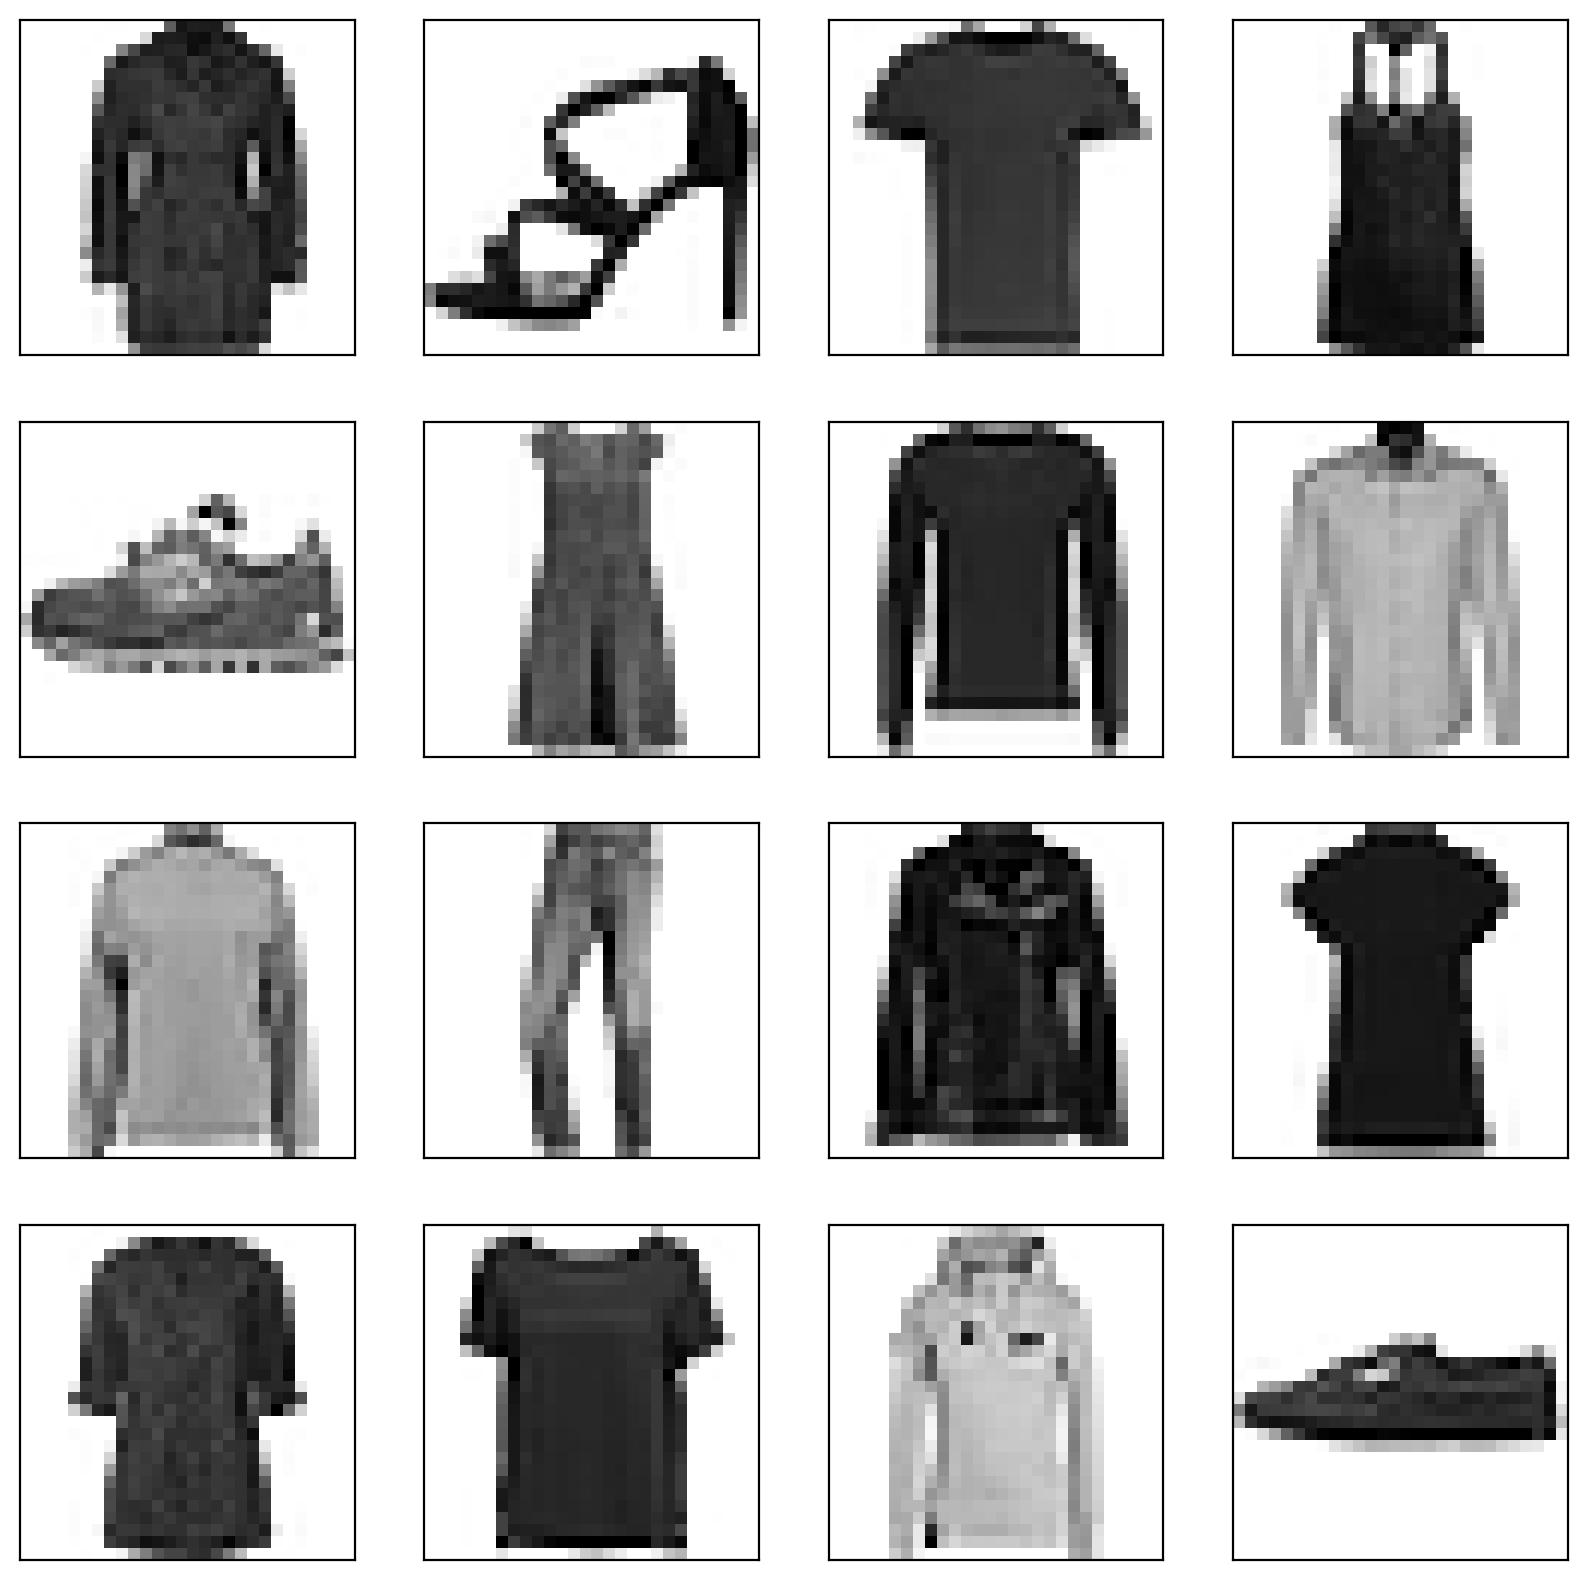

In [5]:
subset = np.random.choice(np.arange(60000), size=16)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img, label = train_data[subset[i]]
    plt.imshow(img.squeeze(), cmap=plt.cm.binary)

plt.show()

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=256, num_workers=4, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=256, num_workers=4, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Funkcje do trenowania i ewaluacji sieci.

In [7]:
def train_network(model, loss_f, opt, train_dataloader, epoch_num):
    # Wpierw przełączamy sieć w tryb uczenia. Tą operację należy wykonać
    # przed każdą sesją trenowania.
    model.train()

    # Pętla po epokach
    for epoch in range(epoch_num):
        epoch_loss, batch_count = 0, 0

        # Pętla po mini-batchach z modułu ładującego dane
        for images, labels in tqdm(train_dataloader):
            # Zerujemy pochodne w algorytmie optymalizacji.
            # Poprzednio operację tą trzeba było wykonać ręcznie.
            opt.zero_grad()

            # Wysyłamy przykłady uczące na kartę graficzną
            images = images.to(device)
            labels = labels.to(device)

            # Operacja feed-forward - wynikiem są logity
            logits = model(images)

            # Teraz możemy obliczyć koszt i wykonać wsteczną propagację błędów
            loss = loss_f(logits, labels)
            loss.backward()

            # Aktualizacja wartości parametrów. W pakiecie optim wystarczy w
            # tym celu wykonać metodę 'step()'
            opt.step()

            epoch_loss += loss.item()
            batch_count += 1

        print(f'Epoka {epoch+1} koszt na zbiorze uczącym: {epoch_loss / batch_count}')

In [8]:
def evaluate_network(model, loss_f, test_dataloader):
    test_loss, batch_count = 0, 0
    correct_predictions  = 0
    example_count = 0

    # Aby móc użyć wytrenowany model musimy przełączyć go w tryb ewaluacji.
    # Operacją tą należy wykonać zanim sieć zostanie wykorzystana do predykcji.
    model.eval()

    # Pętla po przykładach testowych
    for images, labels in tqdm(test_dataloader):

        # Wysyłamy przykłady na kartę graficzną
        images = images.to(device)
        labels = labels.to(device)

        # Operacja feed-forward
        logits = model(images)

        # Jako przewidywaną klasę przyjmujemy klasę z największym logitem
        _, predicted_class = torch.max(logits, 1)

        # Zliczamy prawidłowe predykcje
        correct_predictions += (predicted_class == labels).sum().item()
        example_count += len(predicted_class)

        # Obliczamy wartość kosztu na zbiorze testowym
        loss = loss_f(logits, labels)
        test_loss += loss.item()
        batch_count += 1

    print(f'Dokładność na zbiorze testowym: {correct_predictions / example_count*100:.2f}%')
    print(f'Koszt na zbiorze testowym: {test_loss / batch_count:.2f}')

## Zadanie

Zaimplementuj sieć konwolucyjną do klasyfikacji obrazów ze zbioru `FashionMNIST`. Wynik zapisz w zmiennej `cnn_model`.

W pakiecie PyTorch warstwa konwolucyjna implementowana jest przez metodę `torch.nn.Conv2d`. Implementując sieć posłuż się dokumentacją tej metody. Sieć powinna składać się z:
* Dwóch warstw konwolucyjnych, z których pierwsza ma 4 kanały wyjściowe a druga 32 kanały wyjściowe. Obie warstwy powinny mieć kernele o rozmiarze $(3, 3)$ przesuwane w obu osiach co dwa piksele. Warstwy nie powinny mieć paddingu.
* Warstwy w pełni połączonej wyliczającej logity.

Ponadto:
* Po każdej warstwie konwolucyjnej powinna być dodana warstwa implementująca aktywację `ReLU` oraz warstwa implementująca operację normalizacji aktywacji (`torch.nn.BatchNorm2d`).
* Przed warstwą w pełni połączoną należy dodać warstwę rzutującą wolumen konwolucyjny na wektor liczb.

Zwróć uwagę, że wejściowe obrazy mają jeden kanał (odcienie szarości).

In [9]:
# Implementacja sieci konwolucyjnej
cnn_model = torch.nn.Sequential(
    # Dokończ zgodnie z poleceniem implementację sieci konwolucyjnej.
    # Pierwsza warstwa konwolucyjna
    torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=2, padding=0),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(num_features=4),

    # Druga warstwa konwolucyjna
    torch.nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, stride=2, padding=0),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(num_features=32),

    # Rzutowanie wolumenu konwolucyjnego na wektor liczb
    torch.nn.Flatten(),

    # Warstwa w pełni połączona (logity)
    torch.nn.Linear(32 * 6 * 6, 10)
)

Wysłamy sieć na GPU.

In [10]:
cnn_model.to(device)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU()
  (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2))
  (4): ReLU()
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1152, out_features=10, bias=True)
)

Funkcja kosztu i algorytm optymalizacji.

In [11]:
loss_f = torch.nn.CrossEntropyLoss(reduction='mean')

In [12]:
opt = torch.optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

Trenujemy sieć.

In [13]:
train_network(cnn_model, loss_f, opt, train_dataloader, 20)

 97%|█████████▋| 228/235 [00:11<00:00, 22.66it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 235/235 [00:11<00:00, 20.40it/s]


Epoka 1 koszt na zbiorze uczącym: 0.4983755684913473


100%|██████████| 235/235 [00:10<00:00, 23.39it/s]


Epoka 2 koszt na zbiorze uczącym: 0.3485870945960917


100%|██████████| 235/235 [00:09<00:00, 23.93it/s]


Epoka 3 koszt na zbiorze uczącym: 0.317384834429051


100%|██████████| 235/235 [00:11<00:00, 19.76it/s]


Epoka 4 koszt na zbiorze uczącym: 0.29523402737810256


100%|██████████| 235/235 [00:08<00:00, 29.21it/s]


Epoka 5 koszt na zbiorze uczącym: 0.28052230147605245


100%|██████████| 235/235 [00:06<00:00, 34.49it/s]


Epoka 6 koszt na zbiorze uczącym: 0.2728534681999937


100%|██████████| 235/235 [00:07<00:00, 29.40it/s]


Epoka 7 koszt na zbiorze uczącym: 0.26140545397362813


100%|██████████| 235/235 [00:06<00:00, 34.73it/s]


Epoka 8 koszt na zbiorze uczącym: 0.2536730503782313


100%|██████████| 235/235 [00:08<00:00, 28.93it/s]


Epoka 9 koszt na zbiorze uczącym: 0.24563438727500592


100%|██████████| 235/235 [00:06<00:00, 34.12it/s]


Epoka 10 koszt na zbiorze uczącym: 0.24019646891888152


100%|██████████| 235/235 [00:08<00:00, 29.28it/s]


Epoka 11 koszt na zbiorze uczącym: 0.23686775691965792


100%|██████████| 235/235 [00:07<00:00, 33.37it/s]


Epoka 12 koszt na zbiorze uczącym: 0.23611978806079703


100%|██████████| 235/235 [00:09<00:00, 26.03it/s]


Epoka 13 koszt na zbiorze uczącym: 0.22811566825876844


100%|██████████| 235/235 [00:08<00:00, 28.64it/s]


Epoka 14 koszt na zbiorze uczącym: 0.2280302850489921


100%|██████████| 235/235 [00:06<00:00, 34.56it/s]


Epoka 15 koszt na zbiorze uczącym: 0.22147660889524096


100%|██████████| 235/235 [00:08<00:00, 28.43it/s]


Epoka 16 koszt na zbiorze uczącym: 0.21747908883906425


100%|██████████| 235/235 [00:06<00:00, 33.63it/s]


Epoka 17 koszt na zbiorze uczącym: 0.21772480496066682


100%|██████████| 235/235 [00:08<00:00, 28.95it/s]


Epoka 18 koszt na zbiorze uczącym: 0.21522930090097672


100%|██████████| 235/235 [00:07<00:00, 33.46it/s]


Epoka 19 koszt na zbiorze uczącym: 0.21353487169488947


100%|██████████| 235/235 [00:08<00:00, 28.73it/s]

Epoka 20 koszt na zbiorze uczącym: 0.20974772268153252


I oceniamy jej skuteczność.

In [14]:
evaluate_network(cnn_model, loss_f, test_dataloader)

100%|██████████| 40/40 [00:01<00:00, 29.99it/s]

Dokładność na zbiorze testowym: 88.62%
Koszt na zbiorze testowym: 0.33
